<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><a href="https://xgboost.readthedocs.io/en/latest/index.html" target="_blank">XGBoost</a></a></span><ul class="toc-item"><li><span><a href="#Baseline-Model" data-toc-modified-id="Baseline-Model-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Baseline Model</a></span><ul class="toc-item"><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Prepare Data</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Evaluation</a></span><ul class="toc-item"><li><span><a href="#Average-Treatment-Effect" data-toc-modified-id="Average-Treatment-Effect-1.1.3.1"><span class="toc-item-num">1.1.3.1&nbsp;&nbsp;</span>Average Treatment Effect</a></span></li></ul></li></ul></li><li><span><a href="#New-Model" data-toc-modified-id="New-Model-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>New Model</a></span><ul class="toc-item"><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Prepare Data</a></span><ul class="toc-item"><li><span><a href="#Categorical-Features" data-toc-modified-id="Categorical-Features-1.2.1.1"><span class="toc-item-num">1.2.1.1&nbsp;&nbsp;</span>Categorical Features</a></span></li><li><span><a href="#Pipeline" data-toc-modified-id="Pipeline-1.2.1.2"><span class="toc-item-num">1.2.1.2&nbsp;&nbsp;</span>Pipeline</a></span></li></ul></li><li><span><a href="#Train" data-toc-modified-id="Train-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Evaluation</a></span></li></ul></li></ul></li><li><span><a href="#Features-Importance" data-toc-modified-id="Features-Importance-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Features Importance</a></span><ul class="toc-item"><li><span><a href="#SHAP" data-toc-modified-id="SHAP-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span><a href="https://github.com/slundberg/shap" target="_blank">SHAP</a></a></span></li><li><span><a href="#XGBoost-features-importance" data-toc-modified-id="XGBoost-features-importance-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span><a href="https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score" target="_blank">XGBoost features importance</a></a></span></li></ul></li><li><span><a href="#Practical-Lessons-From-Facebook" data-toc-modified-id="Practical-Lessons-From-Facebook-3"><span class="toc-item-num">3&nbsp;&nbsp;</span><a href="https://quinonero.net/Publications/predicting-clicks-facebook.pdf" target="_blank">Practical Lessons From Facebook</a></a></span><ul class="toc-item"><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Prepare Data</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Evaluation</a></span><ul class="toc-item"><li><span><a href="#Make-a-Submission" data-toc-modified-id="Make-a-Submission-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Make a Submission</a></span></li></ul></li></ul></li></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2

Продолжаем работать над задачей CTR-prediction с использованием датасета от Criteo.

Описание задачи и данных можно посмотреть в notebook'e предыдущей практики (`sgd_logreg_nn/notebooks/ctr_prediction_mllib.ipynb`).

# [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html)


Утановим xgboost

In [2]:
!pip3.5 install xgboost

In [3]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
from typing import Dict
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pyspark
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql import Row


sys.path.append('./utils')

os.environ['PYSPARK_SUBMIT_ARGS'] = """
--jars xgboost4j-spark-0.72.jar,xgboost4j-0.72.jar
--py-files sparkxgb.zip pyspark-shell
""".replace('\n', ' ')

spark = SparkSession \
    .builder \
    .master('local[*]') \
    .appName("spark_sql_examples") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

from metrics import rocauc, logloss, ne, calibration, df_with_proba_column
from processing import split_by_col

from sparkxgb.xgboost import *

Обратите внимание на слудующие строки:

* ```python
sys.path.append('./utils')
...
from metrics import rocauc, logloss, ne
from processing import split_by_col
```

В папке `utils` находится два файла (`metrics.py`, `processing.py`), которые содержат функции, которые нужно было реализовать в рамках предыдущей практики.


* ```python
os.environ['PYSPARK_SUBMIT_ARGS'] = """
--jars xgboost4j-spark-0.72.jar,xgboost4j-0.72.jar
--py-files sparkxgb.zip pyspark-shell
"""
...
from sparkxgb.xgboost import *
```

Для того чтобы в рамках инфраструктуры Spark можно было использовать XGBoost, мы воспользуемся библиотекой [XGBoost4J](https://xgboost.readthedocs.io/en/latest/jvm/xgboost4j_spark_tutorial.html).

В ходе выполнения занятий может быть полезно ознакомиться с исходным кодом обертки для питона, который находится в архиве `sparkxgb.zip`

In [4]:
DATA_PATH = '/workspace/data/criteo/dac'
TRAIN_PATH = os.path.join(DATA_PATH, 'train.csv')

MODEL_DIR = '/workspace/models/criteo/dac'

In [5]:
SAMPLE_RATE = 0.25
TRAIN_DOWNSAMPLE_RATE = 0.5
SEED=82

In [6]:
all_metrics = {}

## Baseline Model
### Prepare Data

In [7]:
df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TRAIN_PATH)

In [8]:
df = df.sample(False, SAMPLE_RATE, seed=SEED)
df.count()

916399

In [9]:
num_columns = ['_c{}'.format(i) for i in range(1, 14)]
cat_columns = ['_c{}'.format(i) for i in range(14, 40)][:2]
len(num_columns), len(cat_columns)

(13, 2)

In [10]:
df = df.fillna(0, subset=num_columns)

Воспользуемся пайплайном из предыдущей практики

In [11]:
from pyspark.ml import PipelineModel


pipeline_model = PipelineModel.load(os.path.join(DATA_PATH, 'pipeline_model'))

In [12]:
pipeline_model.stages

[StringIndexer_ffdd8d524b01,
 StringIndexer_547ed9cdbe45,
 OneHotEncoderEstimator_b3d576ca1390,
 VectorAssembler_9c298301fb70]

In [13]:
len(pipeline_model.stages[0].labels), len(pipeline_model.stages[1].labels)

(1389, 552)

Итоговая размерность пространства фичей

In [14]:
dim = len(num_columns) + len(pipeline_model.stages[0].labels) + len(pipeline_model.stages[1].labels)
dim

1954

In [15]:
df = pipeline_model \
    .transform(df) \
    .select(F.col('_c0').alias('label'), 'features', 'id') \
    .cache()

df.count()

916399

In [16]:
train_df, val_df, test_df = split_by_col(df, 'id', [0.8, 0.1, 0.1])
train_df = train_df.sample(False, TRAIN_DOWNSAMPLE_RATE, seed=SEED)
train_df.count()

366136

### Train

In [17]:
estimator = XGBoostEstimator(
    featuresCol="features", 
    labelCol="label", 
    predictionCol="prediction",
    colsample_bytree=0.9,
    eta=0.15,
    gamma=0.9,
    max_depth=8,
    min_child_weight=50.0,
    subsample=0.9,
    objective='binary:logistic',
    eval_metric='logloss', 
    silent=0,
    num_round=20,
    nthread=1,
    nworkers=1
)

In [18]:
model = estimator.fit(train_df)

Сохраняем [booster](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster) обученной модели

In [19]:
XGB_BASELINE_PATH = os.path.join(MODEL_DIR, 'xgb.model')

model._call_java("booster").saveModel(XGB_BASELINE_PATH)

### Evaluation

#### Average Treatment Effect

Пусть даны две экспериментальные группы treatment ($T$) и control ($C$), где

* `treatment` - группа с изменением (например, новая модель)
* `control` - группа без изменений

Рассмотрим метрику $X$, значение которой мы расчитали для наших групп ($X_T, X_C$).

Тогда под ATE будем иметь в виду
$$ \Delta\% = \frac{X_T - X_C}{X_C} \cdot 100 $$

In [20]:
def get_ate(groups, control_name) -> pd.DataFrame:
    """Get Average Treatment Effect
    groups - dictionary where keys - names of models, values - dicts of pairs <metric_name>, <metric_value>
    control_name - name of baseline model
    
    return pd.DataFrame (rows corresponds to metrics, cols corresponds to models and ATE with respect to control)
    """
    
    metric_names = []
    for metric_name_values in groups.values():
        for metric_name, _ in metric_name_values.items():
            if metric_name not in metric_names:
                metric_names.append(metric_name)
    metric_names = list(sorted(metric_names))
    
    if control_name not in groups:
        raise ValueError("Control experiment is not in the group.")
    control_values = groups[control_name]
    if len(control_values) != len(metric_names):
        raise ValueError("Control experiment does not have all the metrics computed.")

    model_names = list(sorted(groups.keys()))
    metric_model_ates = []
    for metric_name in metric_names:
        control_value = control_values[metric_name]
        model_ates = []
        for model_name in model_names:
            if metric_name in groups[model_name]:
                ate = (groups[model_name][metric_name] - control_value) / control_value * 100
            else:
                ate = None
            model_ates.append(ate)
        metric_model_ates.append(model_ates)

    ates_df = pd.DataFrame(data=metric_model_ates, index=metric_names, columns=model_names)
    return ates_df

In [21]:
ROC_AUC_HANDLE = 'Area Under ROC'
CALIBRATION_HANDLE = 'Calibration'

In [22]:
baseline_metrics = {}
baseline_metrics[ROC_AUC_HANDLE] = rocauc(model, test_df, probabilities_col='probabilities')
baseline_metrics[CALIBRATION_HANDLE] = calibration(model, test_df, probabilities_col='probabilities')
baseline_metrics

{'Area Under ROC': 0.7241936356631233, 'Calibration': 0.686468921846359}

In [23]:
XGB_BASELINE_HANDLE = '1.xgb_baseline'
all_metrics[XGB_BASELINE_HANDLE] = baseline_metrics

Сравним результаты с логрег моделью из предыдущей практики.

1. Загрузить обученную `LogReg` модель
2. Посчитать метрики на `test_df`

In [24]:
from pyspark.ml.classification import LogisticRegressionModel


LOG_REG_MODEL_PATH = os.path.join(MODEL_DIR, 'log_reg_model')

log_reg_model = LogisticRegressionModel.load(LOG_REG_MODEL_PATH)

In [25]:
log_reg_metrics = {}
log_reg_metrics[ROC_AUC_HANDLE] = rocauc(log_reg_model, test_df)
log_reg_metrics[CALIBRATION_HANDLE] = calibration(log_reg_model, test_df)
log_reg_metrics

{'Area Under ROC': 0.7011126438390733, 'Calibration': 0.8353607732044659}

In [26]:
LOG_REG_HANDLE = '2.logistic_regression'
all_metrics[LOG_REG_HANDLE] = log_reg_metrics

Построить таблицу ATE используя метод `get_ate`

In [27]:
get_ate(all_metrics, XGB_BASELINE_HANDLE)

,1.xgb_baseline,2.logistic_regression
Area Under ROC,0.0,-3.187130
Calibration,0.0,21.689525


## New Model
### Prepare Data

In [28]:
df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TRAIN_PATH)
df = df.sample(False, SAMPLE_RATE, seed=SEED)
df = df.fillna(0, subset=num_columns)

#### Categorical Features

See [Doc](https://spark.apache.org/docs/latest/ml-pipeline.html) for additional details on Transformers and Encoders.

Implement classes below

In [29]:
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param, Params
from pyspark import keyword_only


class MeanTargetEncoderModel(
    pyspark.ml.Model,
    HasInputCol,
    HasOutputCol,
    pyspark.ml.util.DefaultParamsWritable,
    pyspark.ml.util.DefaultParamsReadable):
    """Fitted Model"""
    
    def __init__(self):        
        super(MeanTargetEncoderModel, self).__init__()
        self.inputOutputMapping = Param(self, "inputOutputMapping", "inputOutputMapping")
        self._setDefault(inputOutputMapping={})

    @keyword_only
    def setParams(self, inputCol, outputCol, inputOutputMapping):
        kwargs = self._input_kwargs
        return self._set(**kwargs)

    def setInputOutputMapping(self, value):
        return self._set(inputOutputMapping=value)

    def getInputOutputMapping(self):
        return self.getOrDefault(self.inputOutputMapping)
        
    def transform(self, dataset: pyspark.sql.DataFrame) -> pyspark.sql.DataFrame:
        inputOutputMapping = self.getInputOutputMapping()
        def map_column_using_mapping(input_value, default_value=0.0):
            return inputOutputMapping.get(input_value, default_value)
    
        map_column_using_mapping_udf = F.udf(map_column_using_mapping, FloatType())

        return dataset \
            .withColumn(self.getOutputCol(), map_column_using_mapping_udf(self.getInputCol()))


class MeanTargetEncoder(pyspark.ml.Estimator):
    """Estimator"""

    def __init__(self, inputCol: str, featuresCol: str, outputCol: str,):
        self.inputCol = inputCol
        self.featuresCol = featuresCol
        self.outputCol = outputCol
    
    def fit(self, dataset: pyspark.sql.DataFrame) -> MeanTargetEncoderModel:
        inputOutputMapping = dataset \
            .groupby(self.inputCol) \
            .agg(F.mean(self.featuresCol).alias(self.outputCol)) \
            .select(F.col(self.inputCol), F.col(self.outputCol)) \
            .rdd \
            .collectAsMap()
        mte_model = MeanTargetEncoderModel()
        mte_model.setParams(
            inputCol=self.inputCol, outputCol=self.outputCol, inputOutputMapping=inputOutputMapping)
        return mte_model

In [30]:
cat_enc_columns = [cat_col + '_enc' for cat_col in cat_columns]

cat_col, cat_enc_col = cat_columns[0], cat_enc_columns[0]
mean_target_encoder = MeanTargetEncoder(cat_col, '_c0', cat_enc_col)
mean_target_encoder_model = mean_target_encoder.fit(df)

In [31]:
mean_target_encoder_model.transform(df).take(1)

[Row(_c0=1, _c1=0, _c2=2, _c3=11, _c4=5, _c5=10262, _c6=34, _c7=2, _c8=4, _c9=5, _c10=0, _c11=1, _c12=0, _c13=5, _c14='be589b51', _c15='287130e0', _c16='cd7a7a22', _c17='fb7334df', _c18='25c83c98', _c19=None, _c20='6cdb3998', _c21='361384ce', _c22='a73ee510', _c23='3ff10fb2', _c24='5874c9c9', _c25='976cbd4c', _c26='740c210d', _c27='1adce6ef', _c28='310d155b', _c29='07eb8110', _c30='07c540c4', _c31='891589e7', _c32='18259a83', _c33='a458ea53', _c34='a0ab60ca', _c35=None, _c36='32c7478e', _c37='a052b1ed', _c38='9b3e8820', _c39='8967c0d2', id=13, _c14_enc=0.25478067994117737)]

#### Pipeline

In [32]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler


cat_enc_columns = [cat_col + '_enc' for cat_col in cat_columns]

mean_target_encoders = [MeanTargetEncoder(cat_col, '_c0', cat_enc_col) 
                        for cat_col, cat_enc_col in zip(cat_columns, cat_enc_columns)]

assembler = VectorAssembler(inputCols=num_columns + cat_enc_columns, outputCol="features").setHandleInvalid("keep")

pipeline = Pipeline(stages=mean_target_encoders + [assembler])

In [33]:
MTE_PIPELINE_MODEL_PATH = os.path.join(DATA_PATH, 'pipeline_model_2')

pipeline_model = pipeline.fit(df)
pipeline_model.write().overwrite().save(MTE_PIPELINE_MODEL_PATH)

In [34]:
from pyspark.ml import PipelineModel


pipeline_model = PipelineModel.load(MTE_PIPELINE_MODEL_PATH)
pipeline_model.stages

[MeanTargetEncoderModel_a54749c774e0,
 MeanTargetEncoderModel_08f9d6e23c13,
 VectorAssembler_efb050c49f0e]

In [35]:
df = pipeline_model \
    .transform(df) \
    .select(F.col('_c0').alias('label'), 'features', 'id') \
    .cache()

df.count()

916399

In [36]:
train_df, val_df, test_df = split_by_col(df, 'id', [0.8, 0.1, 0.1])
train_df = train_df.sample(False, TRAIN_DOWNSAMPLE_RATE, seed=SEED)

In [37]:
train_df.take(1)

[Row(label=1, features=DenseVector([0.0, 2.0, 11.0, 5.0, 10262.0, 34.0, 2.0, 4.0, 5.0, 0.0, 1.0, 0.0, 5.0, 0.2548, 0.2512]), id=13)]

In [38]:
dim = len(train_df.take(1)[0].features)
dim

15

### Train

Train XGBoost on the new set of features

In [39]:
estimator = XGBoostEstimator(
    featuresCol="features", 
    labelCol="label", 
    predictionCol="prediction",
    colsample_bytree=0.9,
    eta=0.15,
    gamma=0.9,
    max_depth=8,
    min_child_weight=50.0,
    subsample=0.9,
    objective='binary:logistic',
    eval_metric='logloss', 
    silent=0,
    num_round=20,
    nthread=1,
    nworkers=1
)

In [40]:
model = estimator.fit(train_df)

In [41]:
XGB_MTE_PATH = os.path.join(MODEL_DIR, 'xgb.model_2')

model._call_java("booster").saveModel(XGB_MTE_PATH)

### Evaluation

Сравнить результаты новой модели с `xgb_baseline` и `log_reg` с помощью функции `get_ate`

In [42]:
xgb_mte_metrics = {}
xgb_mte_metrics[ROC_AUC_HANDLE] = rocauc(model, test_df, probabilities_col='probabilities')
xgb_mte_metrics[CALIBRATION_HANDLE] = calibration(model, test_df, probabilities_col='probabilities')
xgb_mte_metrics

{'Area Under ROC': 0.7323512122070999, 'Calibration': 0.6368521913014498}

In [43]:
XGB_MTE_HANDLE = '3.xgb_mte'

all_metrics[XGB_MTE_HANDLE] = xgb_mte_metrics

In [44]:
get_ate(all_metrics, XGB_BASELINE_HANDLE)

,1.xgb_baseline,2.logistic_regression,3.xgb_mte
Area Under ROC,0.0,-3.187130,1.126436
Calibration,0.0,21.689525,-7.227819


# Features Importance

## [SHAP](https://github.com/slundberg/shap)

Install SHAP

In [45]:
!pip3.5 install shap

In [46]:
import shap
import xgboost as xgb

# load JS visualization code to notebook
shap.initjs()

bst = xgb.Booster()
bst.load_model(XGB_MTE_PATH)

Python 3.5 support is deprecated; XGBoost will require Python 3.6+ in the near future. Consider upgrading to Python 3.6+.


[18:16:14] WARNING: /workspace/src/learner.cc:556: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility


Имея `booster` модели можно, например, посмотреть на то какие деревья получились в итоге.

In [47]:
print(bst.get_dump(dump_format="text")[0])

0:[f0<0.999998987] yes=1,no=2,missing=1
	1:[f10<1.99999905] yes=3,no=4,missing=3
		3:[f14<0.23287572] yes=7,no=8,missing=7
			7:[f10<0.999998987] yes=15,no=16,missing=15
				15:[f14<0.177276179] yes=31,no=32,missing=31
					31:[f3<426] yes=63,no=64,missing=64
						63:[f4<2250] yes=127,no=128,missing=128
							127:[f1<80] yes=255,no=256,missing=255
								255:leaf=-0.248292193
								256:leaf=-0.198214293
							128:[f5<241] yes=257,no=258,missing=258
								257:leaf=-0.255486012
								258:leaf=-0.267750651
						64:[f4<129834] yes=129,no=130,missing=130
							129:[f7<4324] yes=259,no=260,missing=260
								259:leaf=-0.239589453
								260:leaf=-0.213284671
							130:leaf=-0.269604445
					32:[f2<13.999999] yes=65,no=66,missing=65
						65:[f7<3.99999905] yes=131,no=132,missing=131
							131:[f4<129834] yes=261,no=262,missing=262
								261:leaf=-0.193429753
								262:leaf=-0.240568727
							132:[f4<41083] yes=263,no=264,missing=264
								263:leaf=-0.224550381
								

In [48]:
sample_df = df.sample(False, 0.05, seed=SEED)
sample_df.count()

45607

In [49]:
from pyspark.ml.linalg import DenseVector, SparseVector, _convert_to_vector
from scipy.sparse import csr_matrix


def df_to_csr(df, dim):
    data = []
    row_ind = []
    col_ind = []
    
    vecs = df.rdd.map(lambda row: row.features).collect()
    for i, vec in enumerate(vecs):
        if isinstance(vec, SparseVector):
            indices = vec.indices
        elif isinstance(vec, DenseVector):
            indices = range(len(vec))
        else:
            raise NotImplementedValue()
        
        for idx, val in zip(indices, vec.values):
            data.append(val)
            row_ind.append(i)
            col_ind.append(idx)
        
    return csr_matrix((data, (row_ind, col_ind)), shape=(len(vecs), dim))

In [50]:
%%time
X = df_to_csr(sample_df, dim)
dtest = xgb.DMatrix(X)

CPU times: user 898 ms, sys: 11.5 ms, total: 909 ms
Wall time: 1.46 s


In [51]:
X_arr = X.toarray()

In [52]:
%%time
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(dtest, tree_limit=20)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


CPU times: user 1min 1s, sys: 0 ns, total: 1min 1s
Wall time: 5.32 s


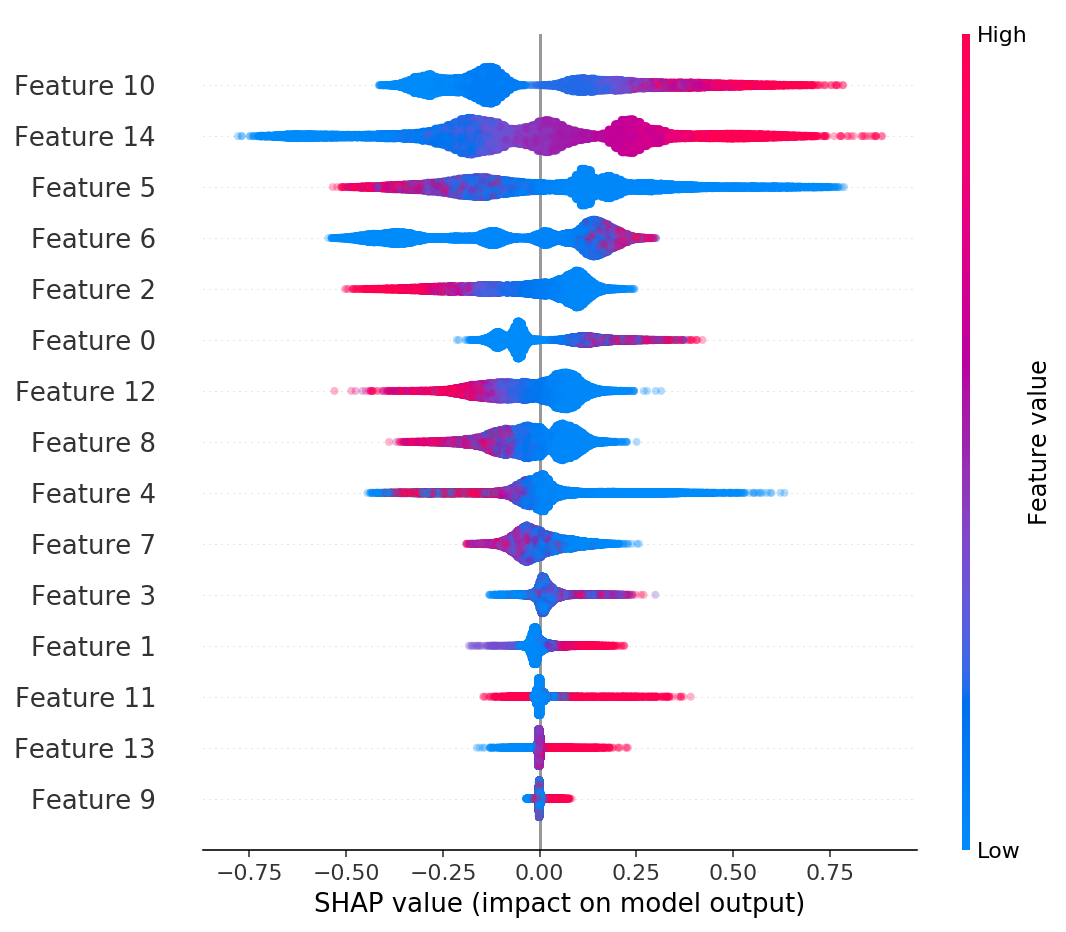

In [53]:
shap.summary_plot(shap_values, X_arr, max_display=20, alpha=0.3)

## [XGBoost features importance](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score)

In [54]:
def get_feature_score(booster, importance):
    gains_xgb = booster.get_score(importance_type=importance)
    gains = {}
    for f, g in gains_xgb.items():
        gains[f] = g
    sorted_gains = sorted(list(gains.items()), key=lambda x: -x[1])
    return sorted_gains


features_scores = get_feature_score(bst, 'gain')[:20]

In [55]:
import pandas as pd


f_names, f_scores = zip(*features_scores)
features_scores_pdf = pd.DataFrame({'feature': f_names, 'gain': f_scores})

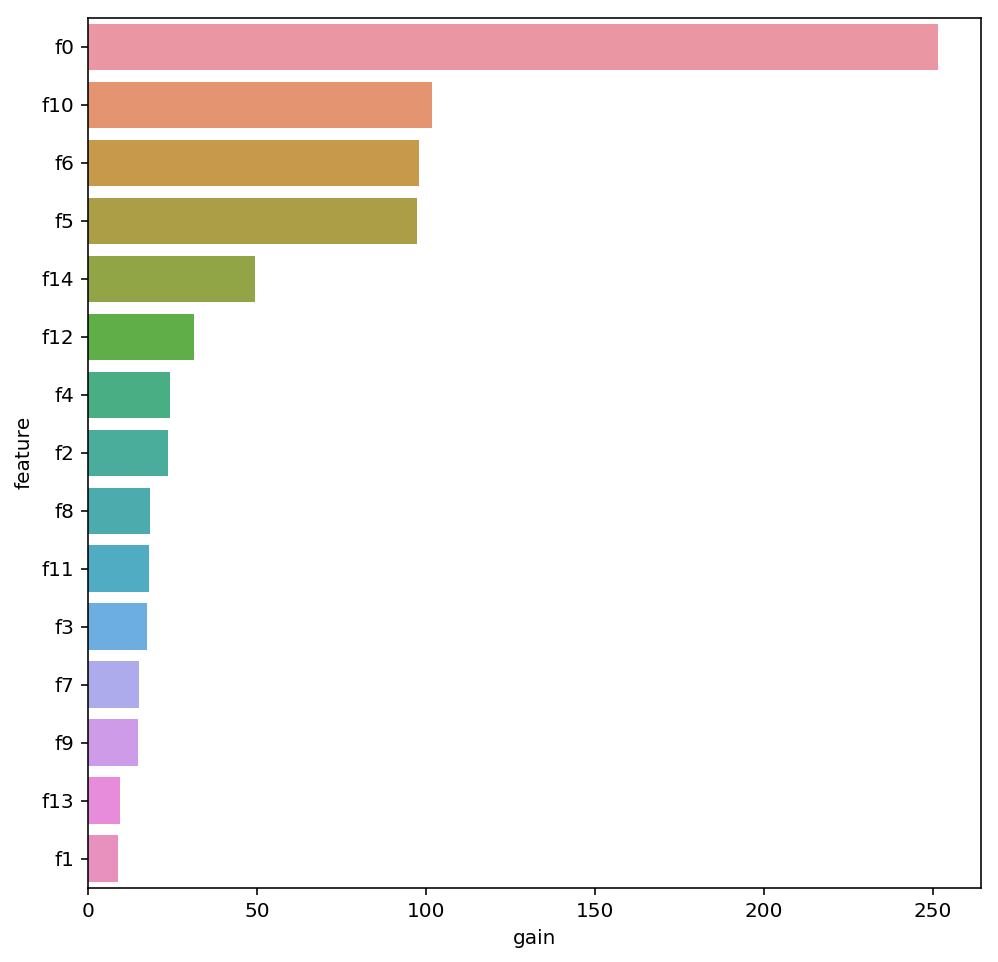

In [56]:
import seaborn as sns


_, ax = plt.subplots(figsize=(8,8))
ax = sns.barplot(x='gain', y='feature', data=features_scores_pdf)
plt.show()

# [Practical Lessons From Facebook](https://quinonero.net/Publications/predicting-clicks-facebook.pdf)

## Prepare Data

* Реализуйте модель из статьи (LogReg поверх XGBoost)

* Попробуйте реализовать Negatives Subsampling + Re-calibration описанный в статье (доп. баллы)

In [57]:
df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TRAIN_PATH) \
    .fillna(0, subset=num_columns)
df = df.sample(False, SAMPLE_RATE, seed=SEED)

In [58]:
pipeline_model = PipelineModel.load(MTE_PIPELINE_MODEL_PATH)
pipeline_model.stages

[MeanTargetEncoderModel_a54749c774e0,
 MeanTargetEncoderModel_08f9d6e23c13,
 VectorAssembler_efb050c49f0e]

In [59]:
df = pipeline_model \
    .transform(df) \
    .select(F.col('_c0').alias('label'), 'features', 'id') \
    .cache()

df.count()

916399

In [60]:
def add_tree_leaves_to_row(row, has_label=True):
    result = [row.id]
    if has_label:
        result.append(row.label)

    samples = np.array([row.features.toArray()])
    xgb_matrix = xgb.DMatrix(samples)
    bst = xgb.Booster()
    bst.load_model(XGB_MTE_PATH)
    leaves = bst.predict(xgb_matrix, pred_leaf=True)[0]
    for leaf in leaves:
        result.append(int(leaf))
    return result

bst = xgb.Booster()
bst.load_model(XGB_MTE_PATH)
num_trees = len(bst.get_dump())
leaf_columns = ["leaf" + str(leaf_num) for leaf_num in range(num_trees)]

df = df \
    .rdd \
    .map(lambda row: add_tree_leaves_to_row(row, has_label=True)) \
    .toDF(["id", "label"] + leaf_columns) \
    .cache()

df.head()

[18:16:44] WARNING: /workspace/src/learner.cc:556: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility


Row(id=13, label=1, leaf0=299, leaf1=277, leaf2=288, leaf3=261, leaf4=295, leaf5=294, leaf6=306, leaf7=412, leaf8=330, leaf9=365, leaf10=279, leaf11=353, leaf12=284, leaf13=306, leaf14=291, leaf15=315, leaf16=173, leaf17=251, leaf18=174, leaf19=178)

In [61]:
from pyspark.ml.feature import OneHotEncoderEstimator

leaf_encoded_columns = [leaf_col + '_enc' for leaf_col in leaf_columns]

leaf_encoder = OneHotEncoderEstimator(inputCols=leaf_columns, outputCols=leaf_encoded_columns)

assembler = VectorAssembler(inputCols=leaf_encoded_columns, outputCol="features").setHandleInvalid("keep")

pipeline = Pipeline(stages=[leaf_encoder, assembler])

In [62]:
pipeline_model = pipeline.fit(df)

TREE_PIPELINE_MODEL_PATH = os.path.join(DATA_PATH, 'pipeline_model_3')
pipeline_model.write().overwrite().save(TREE_PIPELINE_MODEL_PATH)

In [63]:
pipeline_model = PipelineModel.load(TREE_PIPELINE_MODEL_PATH)
pipeline_model.stages

[OneHotEncoderEstimator_82df3ffb751e, VectorAssembler_24b7631f3f7a]

In [64]:
df = pipeline_model \
    .transform(df) \
    .select('label', 'features', 'id') \
    .cache()

df.head()

Row(label=1, features=SparseVector(7406, {299: 1.0, 755: 1.0, 1238: 1.0, 1641: 1.0, 2101: 1.0, 2536: 1.0, 2964: 1.0, 3468: 1.0, 3820: 1.0, 4207: 1.0, 4507: 1.0, 4977: 1.0, 5284: 1.0, 5684: 1.0, 6037: 1.0, 6377: 1.0, 6557: 1.0, 6865: 1.0, 7070: 1.0, 7346: 1.0}), id=13)

In [65]:
train_df, val_df, test_df = split_by_col(df, 'id', [0.8, 0.1, 0.1])
# Commented out so we could experiment with taking all positive samples and downsample negatives
# train_df = train_df.sample(False, TRAIN_DOWNSAMPLE_RATE, seed=SEED)

## Train

In [66]:
from pyspark.ml.classification import LogisticRegression

def find_the_best_log_reg_model(train_df, val_df, negative_downsampling_rate):
    best_model = None
    best_rocauc = None
    # For the sake of speed the best parameters across tens of runs are pre-specified
    for regParam in [8e-2, 9e-2, 1e-1, 2e-1, 3e-1]:  # [0.0, 1e-1, 1e-2, 1e-3]:
        for elasticNetParam in [8e-3, 9e-3, 1e-2, 2e-2, 3e-2]:  # [0.0, 1e-1, 1e-2, 1e-3]:
            for standardization in [True]:  # [False, True]:
                lr = LogisticRegression(
                    regParam=regParam, elasticNetParam=elasticNetParam, standardization=standardization,
                    probabilityCol='probabilities')
                lr_model = lr.fit(train_df)
                lr_rocauc = rocauc(
                    lr_model,
                    val_df,
                    probabilities_col='probabilities',
                    negative_downsampling_rate=negative_downsampling_rate)
                if best_rocauc is None or best_rocauc < lr_rocauc:
                    print("regParam={} elasticNetParam={} standardization={}".format(
                        regParam, elasticNetParam, standardization))
                    print("Improved ROCAUC from {} to {} with the params.".format(best_rocauc, lr_rocauc))
                    best_model = lr_model
                    best_rocauc = lr_rocauc
    return best_model, best_rocauc

## Negative subsampling and recalibration

In [67]:
train_df.count()

733119

In [68]:
positive_train_df = train_df.filter(F.col('label') == 1.0)
positive_train_df.count()

187736

In [69]:
negative_train_df = train_df.filter(F.col('label') == 0.0)
negative_train_df.count()

545383

In [79]:
best_model, best_rocauc, best_neg_rate = None, None, None
search_space = [0.05 * segment_id for segment_id in range(8, 12 + 1)]
for negative_downsampling_rate in search_space:
    print('*' * 100)
    print('NEGATIVE DOWNSAMPLING RATE =', negative_downsampling_rate)
    rebalanced_train_df = negative_train_df \
        .sample(False, negative_downsampling_rate, seed=SEED) \
        .union(positive_train_df)
    cur_model, cur_rocauc = find_the_best_log_reg_model(
        rebalanced_train_df,
        val_df,
        negative_downsampling_rate)
    if best_rocauc is None or best_rocauc < cur_rocauc:
        print('Imporved the global best ROCAUC model!')
        best_model = cur_model
        best_rocauc = cur_rocauc
        best_neg_rate = negative_downsampling_rate

****************************************************************************************************
NEGATIVE DOWNSAMPLING RATE = 0.4
regParam=0.08 elasticNetParam=0.008 standardization=True
Improved ROCAUC from None to 0.7365887626821394 with the params.
regParam=0.08 elasticNetParam=0.009 standardization=True
Improved ROCAUC from 0.7365887626821394 to 0.7366003071515426 with the params.
regParam=0.09 elasticNetParam=0.008 standardization=True
Improved ROCAUC from 0.7366003071515426 to 0.736641397483844 with the params.
regParam=0.1 elasticNetParam=0.008 standardization=True
Improved ROCAUC from 0.736641397483844 to 0.7366659513610768 with the params.
Imporved the global best ROCAUC model!
****************************************************************************************************
NEGATIVE DOWNSAMPLING RATE = 0.45
regParam=0.08 elasticNetParam=0.008 standardization=True
Improved ROCAUC from None to 0.7366039913000552 with the params.
regParam=0.08 elasticNetParam=0.009 standar

In [80]:
print(search_space)
best_rocauc, best_neg_rate

[0.4, 0.45, 0.5, 0.55, 0.6000000000000001]


(0.736803135407382, 0.6000000000000001)

In [81]:
LOG_REG_XGB_MODEL_PATH = os.path.join(MODEL_DIR, 'log_reg_xgb_model_' + str(best_neg_rate))

best_model.write().overwrite().save(LOG_REG_XGB_MODEL_PATH)

## Evaluation

In [82]:
# calibration(model, df) is implemented in the utils.metrics.

Сравните новую модель со всеми предыдущими с помощью `get_ate`. При сравнении использовать еще и метрику calibration

In [83]:
logistic_regression_xgb_metrics = {}
logistic_regression_xgb_metrics[ROC_AUC_HANDLE] = rocauc(
    best_model, test_df, probabilities_col='probabilities', negative_downsampling_rate=best_neg_rate)
logistic_regression_xgb_metrics[CALIBRATION_HANDLE] = calibration(
    best_model, test_df, probabilities_col='probabilities', negative_downsampling_rate=best_neg_rate)
logistic_regression_xgb_metrics

{'Area Under ROC': 0.7330406302751802, 'Calibration': 0.6474337610398267}

In [84]:
LOG_REG_XGB_MODEL_HANDLE = '4.logistic_regression_xgb'
all_metrics[LOG_REG_XGB_MODEL_HANDLE] = logistic_regression_xgb_metrics

In [85]:
get_ate(all_metrics, XGB_BASELINE_HANDLE)

,1.xgb_baseline,2.logistic_regression,3.xgb_mte,4.logistic_regression_xgb
Area Under ROC,0.0,-3.187130,1.126436,1.221634
Calibration,0.0,21.689525,-7.227819,-5.686370


### Make a Submission

Если в результате работы получилась модель, которая лучше чем ЛогРег из предыдущей практики, то точно нужно сделать submission.

In [86]:
TEST_DATA_PATH = '/workspace/data/mlbd-20-ctr-prediction-1'
TEST_TEST_PATH = os.path.join(TEST_DATA_PATH, 'test.csv')

comp_df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + TEST_TEST_PATH) \
    .fillna(0, subset=num_columns)

comp_df.count()

917961

In [89]:
pipeline_model = PipelineModel.load(MTE_PIPELINE_MODEL_PATH)
pipeline_model.stages

[MeanTargetEncoderModel_a54749c774e0,
 MeanTargetEncoderModel_08f9d6e23c13,
 VectorAssembler_efb050c49f0e]

In [90]:
comp_df = pipeline_model \
    .transform(comp_df) \
    .select('features', 'id') \
    .cache()

In [91]:
comp_df = comp_df \
    .rdd \
    .map(lambda row: add_tree_leaves_to_row(row, has_label=False)) \
    .toDF(["id"] + leaf_columns) \
    .cache()

In [92]:
pipeline_model = PipelineModel.load(TREE_PIPELINE_MODEL_PATH)
pipeline_model.stages

[OneHotEncoderEstimator_82df3ffb751e, VectorAssembler_24b7631f3f7a]

In [93]:
comp_df = pipeline_model \
    .transform(comp_df) \
    .select('features', 'id') \
    .cache()

In [94]:
comp_df = df_with_proba_column(
    best_model, comp_df, probabilities_col='probabilities', negative_downsampling_rate=best_neg_rate)

In [95]:
comp_df.take(1)

[Row(features=SparseVector(7406, {314: 1.0, 797: 1.0, 1302: 1.0, 1719: 1.0, 2166: 1.0, 2583: 1.0, 3002: 1.0, 3420: 1.0, 3773: 1.0, 4155: 1.0, 4569: 1.0, 4945: 1.0, 5325: 1.0, 5663: 1.0, 6037: 1.0, 6355: 1.0, 6590: 1.0, 6837: 1.0, 7129: 1.0, 7381: 1.0}), id=566935904713, rawPrediction=DenseVector([0.1523, -0.1523]), probabilities=DenseVector([0.538, 0.462]), prediction=0.0, proba=0.3400358259677887)]

In [96]:
comp_predictions = comp_df \
    .rdd \
    .map(lambda row: (row.id, row.proba)) \
    .collect()

In [97]:
submission_path = os.path.join(TEST_DATA_PATH, 'submission_logistic_regression_xgb.csv')
with open(submission_path, 'w') as writer:
    writer.write("id,proba\n")
    for row in comp_predictions:
        writer.write(",".join(map(str, row))+"\n")